*Ewing et al (2020) Structural variants at the BRCA1/2 loci are a common source of homologous repair deficiency in high grade serous ovarian carcinoma.*

# Notebook 5 - Relative enrichment of HRD samples in samples with mutational events at BRCA1/2 

This notebook investigates the relationship between mutations at BRCA1/2 and HRD in a univariate manner. It contains the analysis and code behind Figure 3.

## Load packages and sample information

In [ ]:
library(ggplot2)
library(RColorBrewer)
library(ggpubr)
library(exact2x2)

In [1]:
sampleInfo<-read.table("SampleInformation.txt",sep="\t",header=T,stringsAsFactors=F)
rownames(sampleInfo)<-sampleInfo[,1]

sampleInfo[sampleInfo$BRCAstatus=="None" & sampleInfo$BRCA1_pro_meth==1,"BRCAstatus"]<-"BRCA1 promoter methylation"
sampleInfo[sampleInfo$BRCAstatus=="BRCA1 promoter methylation","BRCAstatus_compound"]<-"BRCA1 promoter methylation"

In [ ]:
hrd<-sampleInfo[sampleInfo$HRDetect>0.7,]

In [5]:
sampleInfo$Cohort<-substr(sampleInfo$Sample,1,2)
sampleInfo$HRDeficient<-ifelse(sampleInfo$HRDetect>0.7,1,0)

dat<-sampleInfo[sampleInfo$BRCA1_pro_meth!=1,]

Loading required package: magrittr
Loading required package: exactci
Loading required package: ssanv


## Define mutational categories at BRCA1/2

In [ ]:
dat$BRCAstatus<-as.factor(dat$BRCAstatus)
dat$BRCAstatus <- relevel(dat$BRCAstatus, ref = "None")

dat$BRCAstatus_grpsvs<-as.character(dat$BRCAstatus)
dat$BRCAstatus_grpsvs_av<-as.character(dat$BRCAstatus)


dat[(dat$BRCAstatus=="Germline SNV"|dat$BRCAstatus=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCAstatus_grpsvs_av"]<-"SNV only"

dat[(dat$BRCAstatus=="Germline SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCAstatus_grpsvs"]<-"Germline SNV only"

dat[(dat$BRCAstatus=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent'  ,
   "BRCAstatus_grpsvs"]<-"Somatic SNV only"


dat[dat$BRCAstatus=="Deletion overlapping exon (LOF)"  ,
    "BRCAstatus_grpsvs"]<-"Deletion"

dat[(dat$BRCAstatus!="Germline SNV" & dat$BRCAstatus!="Somatic SNV" &
     dat$BRCAstatus!="None"& dat$BRCAstatus!="BRCA1 promoter methylation" & dat$BRCAstatus!="Deletion overlapping exon (LOF)" &
     dat$BRCAstatus!="Complex combination of SV intervals including 1+ LOF (CPX: LOF)" ) ,
    "BRCAstatus_grpsvs_av"]<-"Non-deletion structural variant"

dat[dat$BRCA1status=="Inversion spanning gene (INV_SPAN)" & dat$BRCA2status=="None" ,
    "BRCAstatus_grpsvs"]<-"BRCA1 inversion"


dat[dat$BRCA2status=="Duplication spanning gene (COPY_GAIN)" & dat$BRCA1status=="None" ,
    "BRCAstatus_grpsvs"]<-"BRCA2 duplication"


dat[((dat$BRCAstatus_compound=="SNV + deletion (same gene)")|(dat$BRCAstatus_compound=="SNV + deletions (both genes)"))
  , "BRCAstatus_grpsvs_av"]<-"SNV+same_orboth"

## Run Fishers' exact tests of enrichment

Test for enrichment of samples with mutational events at BRCA1/2 in HRD samples relative to sample with no BRCA1/2 mutational events. P-values corrected for multiple testing. 

In [ ]:
HRDrisk_enrichment<-data.frame()

#Germline SNV
    dat2<-dat[dat$BRCAstatus_grpsvs %in% c("Germline SNV only","None"),]
    dat2$BRCAstatus_grpsvs<-factor(dat2$BRCAstatus_grpsvs,levels=c("None","Germline SNV only"))
    gsnvnondel<-exact2x2(dat2$BRCAstatus_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(gsnvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs)[2],gsnvnondel$estimate,gsnvnondel$conf.int,gsnvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#Somatic SNV
    dat2<-dat[dat$BRCAstatus_grpsvs %in% c("Somatic SNV only","None"),]
    dat2$BRCAstatus_grpsvs<-factor(dat2$BRCAstatus_grpsvs,levels=c("None","Somatic SNV only"))
    gsnvnondel<-exact2x2(dat2$BRCAstatus_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(gsnvnondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs)[2],gsnvnondel$estimate,gsnvnondel$conf.int,gsnvnondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#Single deletion at BRCA1
    dat2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)" & 
    dat$BRCA1status=="Deletion overlapping exon (LOF)"),]
    dat2$grp<-"Single del"
    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","Single del"))
    singledel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(singledel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],singledel$estimate,singledel$conf.int,singledel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#Single deletion at BRCA2
    dat2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)" & 
    dat$BRCA2status=="Deletion overlapping exon (LOF)"),]
    dat2$grp<-"Single del"
    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","Single del"))
    singledel<-exact2x2(dat4$grp,dat4$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(singledel$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],singledel$estimate,singledel$conf.int,singledel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#Double deletion
    dat2<-dat[(dat$BRCAstatus_SV=="Double deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)"),]
    dat2$grp<-"Double deletion"
    dat3<-dat[dat$BRCAstatus=="None" ,]
    dat3$grp<-"None"
    dat4<-rbind(dat2,dat3)
    dat4$grp<-factor(dat4$grp,levels=c("None","Double deletion"))

    f_pseudo<-exact2x2(matrix(c(65,26,1,8),byrow=TRUE,nrow=2),tsmethod="central")
    adj_pvalue<-p.adjust(f_pseudo$p.value,method="BH",n=13)
    res<-c(dim(dat2)[1],f_pseudo$estimate,f_pseudo$conf.int,f_pseudo$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#SNV+deletion (same gene)
    dat3<-dat[dat$BRCAstatus_compound %in% c("SNV + deletion (same gene)","None"),]
    dat3$BRCAstatus_compound<-factor(dat3$BRCAstatus_compound)
    snv_del<-exact2x2(dat3$BRCAstatus_compound,dat3$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snv_del$p.value,method="BH",n=13)
    res<-c(table(dat3$BRCAstatus_compound)[2],snv_del$estimate,snv_del$conf.int,snv_del$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#SNV+deletion (both genes):
    dat3<-dat[dat$BRCAstatus_compound %in% c("SNV + deletions (both genes)","None"),]
    dat3$BRCAstatus_compound<-factor(dat3$BRCAstatus_compound)
    snv_del<-exact2x2(dat3$BRCAstatus_compound,dat3$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(snv_del$p.value,method="BH",n=13)
    res<-c(table(dat3$BRCAstatus_compound)[2],snv_del$estimate,snv_del$conf.int,snv_del$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)

#BRCA1 inversions
    dat2<-dat[dat$BRCAstatus_grpsvs %in% c("BRCA1 inversion","None"),]
    dat2$BRCAstatus_grpsvs<-factor(dat2$BRCAstatus_grpsvs,levels=c("None","BRCA1 inversion"))
    nondel<-exact2x2(dat2$BRCAstatus_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs)[2],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)
    brca1invs<-dat2[dat2$BRCAstatus_grpsvs=="BRCA1 inversion",]

#BRCA2 duplications
    dat2<-dat[dat$BRCAstatus_grpsvs %in% c("BRCA2 duplication","None"),]
    dat2$BRCAstatus_grpsvs<-factor(dat2$BRCAstatus_grpsvs,levels=c("None","BRCA2 duplication"))
    nondel<-exact2x2(dat2$BRCAstatus_grpsvs,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus_grpsvs)[2],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)
    brca2dups<-dat2[dat2$BRCAstatus_grpsvs=="BRCA2 duplication",]

#BRCA1 promoter methylation in absense of SNVs or deletions:
    dat2<-sampleInfo[sampleInfo$BRCAstatus %in% c("BRCA1 promoter methylation","None"),]
    dat2$BRCAstatus<-factor(dat2$BRCAstatus,levels=c("None","BRCA1 promoter methylation"))
    nondel<-exact2x2(dat2$BRCAstatus,dat2$HRDeficient,tsmethod="central")
    adj_pvalue<-p.adjust(nondel$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus)[2],nondel$estimate,nondel$conf.int,nondel$p.value,adj_pvalue)

    f_pseudo<-exact2x2(matrix(c(65,26,1,10),byrow=TRUE,nrow=2),tsmethod="central")
    adj_pvalue<-p.adjust(f_pseudo$p.value,method="BH",n=13)
    res<-c(table(dat2$BRCAstatus)[2],f_pseudo$estimate,f_pseudo$conf.int,f_pseudo$p.value,adj_pvalue)
    HRDrisk_enrichment<-rbind(HRDrisk_enrichment,res)


## Results

In [14]:
colnames(HRDrisk_enrichment)<-c("N","OR","LCI","UCI","Pvalue","AdjPvalue")
rownames(HRDrisk_enrichment)<-c("GermlineSNV","SomaticSNV","SingleDeletionBRCA1","SingleDeletionBRCA2","DoubleDeletion",
                                "SNV+deletion_same","SNV+deletion_both","BRCA1Inversion",
                                "BRCA2duplication","PromoterMethylation")
HRDrisk_enrichment

,N,OR,LCI,UCI,Pvalue,AdjPvalue
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
GermlineSNV,15,6.8897321,1.82861078,32.513215,0.0023372542,0.030384305
SomaticSNV,11,24.7753286,3.23647610,1120.802093,0.0001743967,0.002267157
SingleDeletionBRCA1,12,0.5149815,0.05137866,2.674775,0.6492342337,1.000000000
SingleDeletionBRCA2,9,2.0315275,0.37169663,10.312794,0.5063921824,1.000000000
DoubleDeletion,6,19.4002349,2.40587945,896.200773,0.0013150455,0.017095592
SNV+deletion_same,9,19.8422248,2.45484413,917.779060,0.0011959820,0.015547767
SNV+deletion_both,6,12.4324614,1.30055905,612.388813,0.0226822614,0.294869399
BRCA1Inversion,6,2.5313649,0.31759722,20.199359,0.4813407695,1.000000000
BRCA2duplication,6,0.5151130,0.01041891,4.943022,0.9482801031,1.000000000


## Figure 3

### Forest plots (Fig 3a)

SNV        Deletion Non-deletion SV  SNV + deletion     Methylation 
          "red"       "#377EB8"       "#1B9E77"       "#7570B3"       "#E7298A"

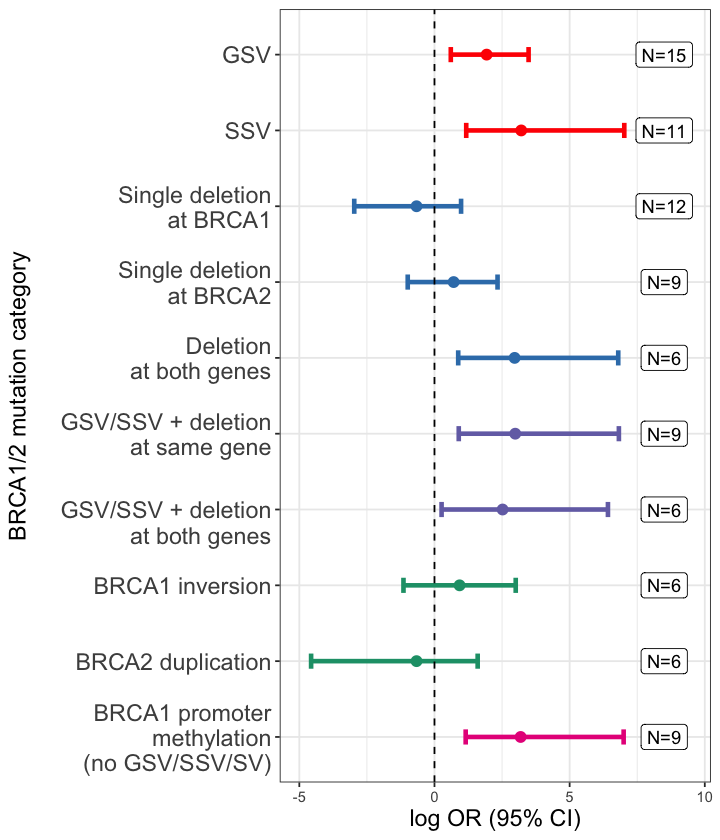

In [15]:
label <- c("GSV","SSV","Single deletion\nat BRCA1","Single deletion\nat BRCA2","\nDeletion\nat both genes\n",
           "\nGSV/SSV + deletion\nat same gene\n","\nGSV/SSV + deletion\nat both genes",
           "BRCA1 inversion","BRCA2 duplication","BRCA1 promoter\nmethylation\n (no GSV/SSV/SV)")
n<-HRDrisk_enrichment[,1]
mean  <- HRDrisk_enrichment[,2]
lower <- HRDrisk_enrichment[,3]
upper <- HRDrisk_enrichment[,4]
col<-c("SNV","SNV","Deletion","Deletion","Deletion","SNV + deletion","SNV + deletion","Non-deletion SV",
       "Non-deletion SV","Methylation")

df <- data.frame(n,label, mean=log(mean), lower=log(lower), upper=log(upper),col=col)
myColors <- c("red","#377EB8",brewer.pal(6,"Dark2")[1],brewer.pal(6,"Dark2")[3],brewer.pal(6,"Dark2")[4])

types<-c("SNV","Deletion","Non-deletion SV","SNV + deletion","Methylation")
names(myColors) <- types

colScale <- scale_colour_manual(name = "BRCA status",values = myColors,breaks=types)

df$label <- factor(df$label, levels=rev(df$label))

options(repr.plot.width=5,repr.plot.height=5)
fp <- ggplot(data=df, aes(x=label, y=mean, ymin=lower, ymax=upper,colour=col)) +
        geom_pointrange() + geom_errorbar(width=0.2,cex=1.3)+
        geom_hline(yintercept=0, lty=2) +  
        coord_flip() +  
        xlab("BRCA1/2 mutation category\n")+ ylab("log OR (95% CI)") +
        annotate("label",y=8.5,x=label,label=paste("N=",df$n,sep=""))+
        theme_bw()  +
        theme(axis.text.y=element_text(size=14),axis.title=element_text(size=14),
            legend.text=element_text(size=12),legend.title=element_text(size=12,face="bold"),
            legend.position="None")+
        ylim(-5,9.5)+
        colScale 

options(repr.plot.width=6,repr.plot.height=7)
fp

### Box plots (Fig 3b)


In [ ]:
#Germline SNV
    hrd_germSNV<-dat[(dat$BRCAstatus=="Germline SNV") & dat$BRCAstatus_SV=='SV absent' ,"HRDetect"]
    df_germ<-data.frame(MutCat="Germline SNV only",HRD=hrd_germSNV,Col="SNV")

#Somatic SNV
    hrd_somSNV<-dat[(dat$BRCAstatus=="Somatic SNV") & dat$BRCAstatus_SV=='SV absent',"HRDetect"]
    df_som<-data.frame(MutCat="Somatic SNV only",HRD=hrd_somSNV,Col="SNV")

#Single BRCA1 deletion
    hrd_singledel_brca1<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)" &
        dat$BRCA1status=="Deletion overlapping exon (LOF)"),"HRDetect"]
    df_brca1del<-data.frame(MutCat="Single deletion at BRCA1",HRD=hrd_singledel_brca1,Col="Deletion")

#Single BRCA2 deletion
    hrd_singledel_brca2<-dat[(dat$BRCAstatus_SV=="Single deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)" &
        dat$BRCA2status=="Deletion overlapping exon (LOF)"),"HRDetect"]
    df_brca2del<-data.frame(MutCat="Single deletion at BRCA2",HRD=hrd_singledel_brca2,Col="Deletion")

#Double deletion
    hrd_doubledel<-dat[(dat$BRCAstatus_SV=="Double deletion" & dat$BRCAstatus=="Deletion overlapping exon (LOF)"),"HRDetect"]
    df_doubledel<-data.frame(MutCat="Double deletion",HRD=hrd_doubledel,Col="Deletion")

#SNV+deletion (same gene)
    hrd_same<-dat[((dat$BRCAstatus_compound=="SNV + deletion (same gene)")), "HRDetect"]
    df_snvdelsame<-data.frame(MutCat="Compound same",HRD=hrd_same,Col="SNV + deletion")

#SNV+deletions (both)
    hrd_both<-dat[((dat$BRCAstatus_compound=="SNV + deletions (both genes)")), "HRDetect"]
    df_snvdelboth<-data.frame(MutCat="Compound both",HRD=hrd_both,Col="SNV + deletion")

#BRCA1 inversion
    hrd_brca1inv<-dat[(dat$BRCA1status=="Inversion spanning gene (INV_SPAN)" & dat$BRCA2status=="None") ,"HRDetect"]
    df_brca1inv<-data.frame(MutCat="BRCA1 inversion",HRD=hrd_brca1inv,Col="Non-deletion SV")

#BRCA2 duplication
    hrd_brca2dups<-dat[(dat$BRCA2status=="Duplication spanning gene (COPY_GAIN)" & dat$BRCA1status=="None") ,"HRDetect"]
    df_brca2dup<-data.frame(MutCat="BRCA2 duplication",HRD=hrd_brca2dups,Col="Non-deletion SV")

#Methylation
    hrd_methyl<-sampleInfo[sampleInfo$BRCAstatus == "BRCA1 promoter methylation","HRDetect"]
    df_methyl<-data.frame(MutCat="Promoter methylation",HRD=hrd_methyl,Col="Methylation")

#Combine
hrd_df<-rbind(df_germ,df_som,df_brca1del,df_brca2del,df_doubledel,df_snvdelsame,df_snvdelboth,df_brca1inv,df_brca2dup,df_methyl)




In [ ]:
hrd_df$MutCat <- factor(hrd_df$MutCat, levels=rev(levels(hrd_df$MutCat)))
myColors <- c("red","#377EB8",brewer.pal(6,"Dark2")[3],brewer.pal(6,"Dark2")[1],brewer.pal(6,"Dark2")[4])
types<-c("SNV","Deletion","SNV + deletion","Non-deletion SV","Methylation")
labels <- c("Germline SNV","Somatic SNV", "Single deletion\nat BRCA1","Single deletion\nat BRCA2","\nDeletion\nat both genes\n",
           "\nSNV + deletion\nat same gene\n","\nSNV + deletion\nat both genes",
           "Non-deletion SV","BRCA1 inversion", "BRCA2 duplication","BRCA1 promoter\nmethylation\n (no SNV/SV)")

boxplot_panel<-ggplot(hrd_df,aes(x=MutCat,y=HRD,colour=Col))+
               geom_boxplot(outlier.shape=NA)+
               geom_jitter(width=0.1)+
               coord_flip()+
               theme_bw()+
               scale_x_discrete(labels=rev(labels))+
               scale_colour_manual(values=myColors,breaks=types)+
               theme(axis.title.x=element_text(size=14),axis.text.y=element_blank(),legend.position="None")+
               xlab("")+
               ylab("HRDetect score")


### Put together forest and boxplots

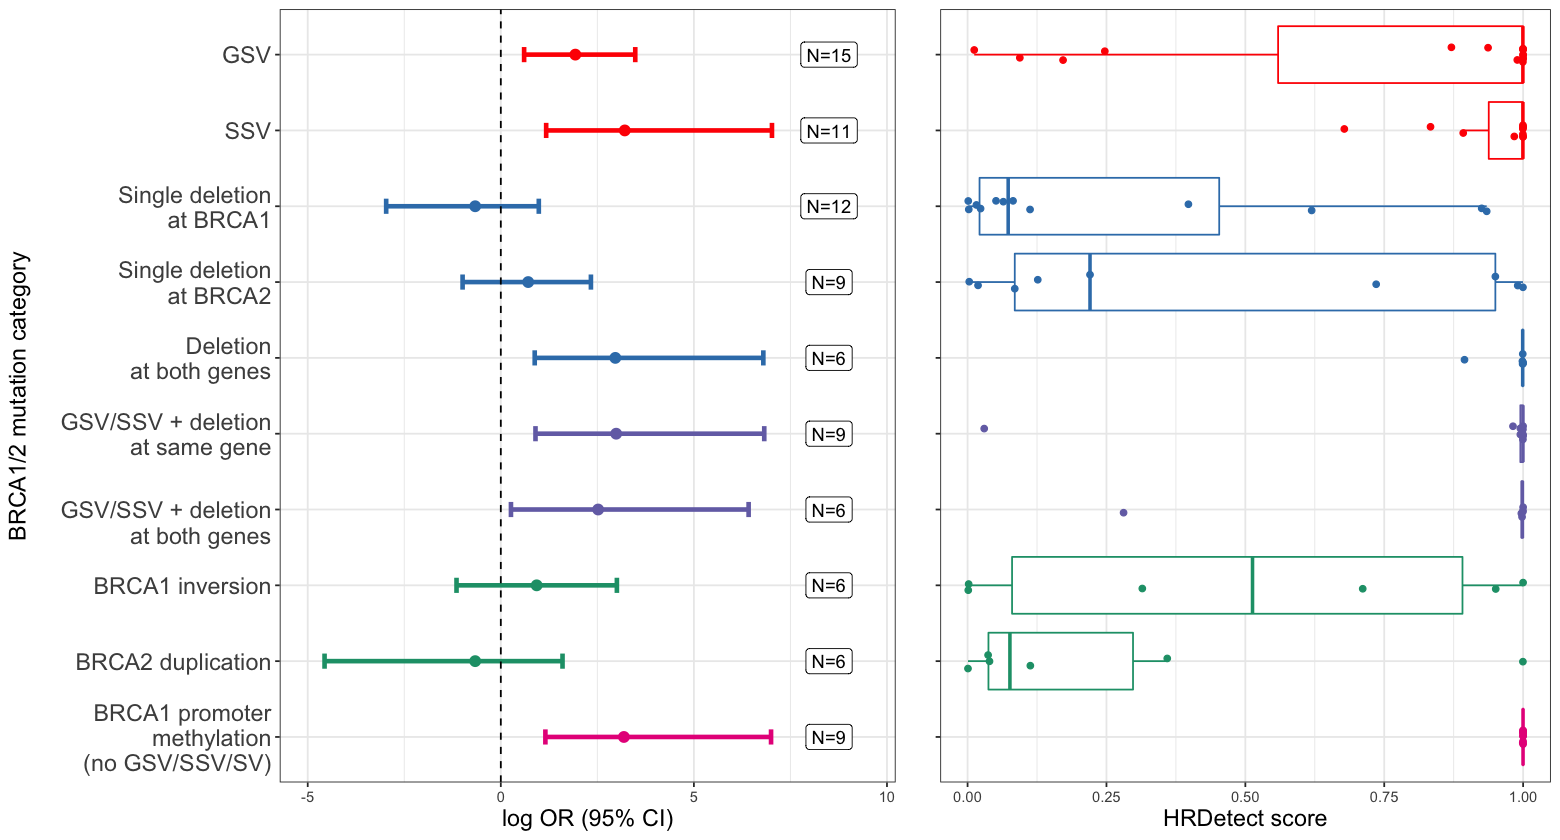

In [21]:
library(cowplot)

options(repr.plot.width=13)
plot_grid(fp, boxplot_panel, align = "h", nrow = 1,rel_widths = c(0.58,0.42))